In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from scipy.stats import norm
from itertools import combinations, permutations, product

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207881 entries, 0 to 207880
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        207881 non-null  object
 1   date      207881 non-null  object
 2   title     207881 non-null  object
 3   body      207881 non-null  object
 4   subjects  207881 non-null  object
 5   category  207881 non-null  object
dtypes: object(6)
memory usage: 11.1+ MB


In [63]:
df['category'].unique()

array(['autot', 'musiikki', 'luonto', 'vaalit', 'taudit', 'työllisyys',
       'jääkiekko', 'kulttuuri', 'rikokset', 'koulut', 'tulipalot',
       'ruoat'], dtype=object)

In [5]:
# df.drop_duplicates('id', inplace=True)

In [6]:
# df.reset_index(inplace=True, drop=True)

In [7]:
# df.to_json('data/dev/cluster_12_cats.json')

In [ ]:
def sample_sigmoid(time_range, n=100, change_rate=0.5):
    x = np.arange(time_range)
    mid = int(time_range / 2)
    y = n + (1 / (1 + np.exp(-0.1* (x-mid) ))) * n * change_rate
    
    plt.figure(figsize=(20, 5))
    plt.plot(x, y)
    plt.show()
    
def sample_bell(time_range, n=100, change_rate=0.5, std=0):
    x = np.arange(time_range)
    mu = int(time_range / 2)
    std = std if std else int(time_range / 5)
    y = norm.pdf(x, mu, std)
    # scale 0-1
    y_min = y.min()
    y_max = y.max()
    y = (y - y_min) / (y_max - y_min)
    # add n docs
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()
    

def sample_linear(time_range, n=100, change_rate=0.5):
    x = np.arange(time_range)
    y = (x - x.min()) / (x.max() - x.min())
    y = n + y * n * change_rate
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, y)
    plt.show()

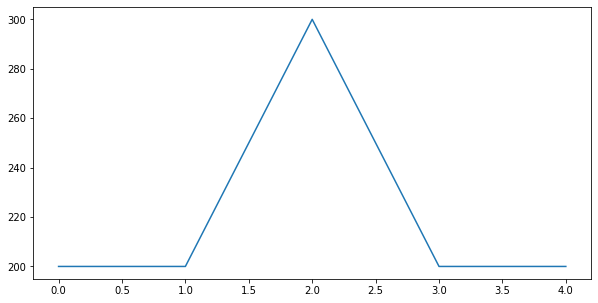

In [9]:
sample_bell(5, n=200, change_rate=0.5, std=0.1)

In [48]:
def linear_pattern(data, n=100, start=0, stop=100, change_rate=1):
    """
    Sampling up pattern, start and end in random points
    """
    # print(lower_p, upper_p)
    # change_points = np.array([0, lower_p, upper_p, timeline], dtype=int)
    sample_list = []
    x = np.arange(start, stop)
    # normalize x to range 0-1
    y = (x - start) / (stop - start)
    n_docs = n + y * n * change_rate
    
    change = 0
    
    for i, t in enumerate(x):
        sample = data.sample(int(n_docs[i]))
        sample['time'] = t
        sample_list.append(sample)
    
    samples = pd.concat(sample_list, ignore_index=True)
    
    return samples, int(n_docs[-1])

def sigmoid_pattern(data, n=100, start=0, stop=100, change_rate=1):
    sample_list = []
    x = np.arange(start, stop)
    mid = int((stop - start) / 2)
    n_docs = n + (1 / (1 + np.exp(-0.1* (x-mid) ))) * n * change_rate
    
    for i, t in enumerate(x):
        sample = data.sample(int(n_docs[i]))
        sample['time'] = t
        sample_list.append(sample)
        
    samples = pd.concat(sample_list, ignore_index=True)
    
    return samples, int(n_docs[-1])

def flat_pattern(data, n=100, start=0, stop=100):
    sample_list = []
    n_doc = 1 if n < 0 else n
    
    for i in np.arange(start, stop):
        sample = data.sample(n_doc)
        sample['time'] = i
        sample_list.append(sample)
        
    samples = pd.concat(sample_list, ignore_index=True)
    
    return samples, n


def bell_pattern(data, n=100, start=0, stop=100, change_rate=1, std=0):
    sample_list = []
    time_range = stop - start
    
    x = np.arange(start, stop)
    mu = int(time_range / 2)
    
    std = std if std else int(time_range / 5)
    y = norm.pdf(np.arange(time_range), mu, std)
    # scale 0-1
    y = (y - y.min()) / (y.max() - y.min())
    # add n docs
    n_docs = n + y * n * change_rate
    
    for i, t in enumerate(x):
        sample = data.sample(int(n_docs[i]))
        sample['time'] = t
        sample_list.append(sample)
        
    samples = pd.concat(sample_list, ignore_index=True)
    
    return samples, int(n_docs[-1])                 


def sample_pattern(pattern, data, n, timeline=100, change_rate=0.01):
    sample = None
    change_points = np.empty(shape=(0,))
    
    if pattern == 'up':
        lower_p = np.random.randint(low=1, high=int(timeline/3))
        upper_p = np.random.randint(low=int(timeline/1.5), high=timeline)
        
        n_doc = int(n * 0.8)
        
        p1, n1 = flat_pattern(data, n=n_doc, start=0, stop=lower_p)
        p2, n2 = sigmoid_pattern(data, n=n1, start=lower_p, stop=upper_p, change_rate=change_rate)
        p3, n3 = flat_pattern(data, n=n2, start=upper_p, stop=timeline)

        sample = pd.concat((p1, p2, p3), ignore_index=True)
        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'down':
        lower_p = np.random.randint(low=1, high=int(timeline/3))
        upper_p = np.random.randint(low=int(timeline/1.5), high=timeline)
        
        n_doc = int(n * 1.4)
        
        p1, n1 = flat_pattern(data, n=n_doc, start=0, stop=lower_p)
        p2, n2 = sigmoid_pattern(data, n=n1, start=lower_p, stop=upper_p, change_rate=-change_rate)
        p3, n3 = flat_pattern(data, n=n2, start=upper_p, stop=timeline)

        sample = pd.concat((p1, p2, p3), ignore_index=True)
        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'periodic':
        n_preiod = np.random.randint(3, 10)
        lower_p = 10
        upper_p = 90
        
        change_points = np.linspace(lower_p, upper_p, n_preiod, dtype=int)
        sample_list = []
        
        n_doc = int(n * 0.8)
        cur_p = 0
        
        for i, p in enumerate(change_points):
            s1, n1 = flat_pattern(data, n=n_doc, start=cur_p, stop=p-2)
            s2, n2 = bell_pattern(data, n=n1, start=p-2, stop=p+2, change_rate=change_rate, std=0.1)
            sample_list.append(s1)
            sample_list.append(s2)
            
            cur_p = p + 2
            
            if i == len(change_points) - 1:
                s3, n3 = flat_pattern(data, n=n_doc, start=cur_p, stop=timeline)
                sample_list.append(s3)
            
        sample = pd.concat(sample_list, ignore_index=True)
        
        
    elif pattern == 'up_down':
        lower_p = np.random.randint(low=1, high=int(timeline/3))
        upper_p = np.random.randint(low=int(timeline/1.5), high=timeline)
        
        n_doc = int(n * 0.8)
        
        p1, n1 = flat_pattern(data, n=n_doc, start=0, stop=lower_p)
        p2, n2 = bell_pattern(data, n=n1, start=lower_p, stop=upper_p, change_rate=change_rate)
        p3, n3 = flat_pattern(data, n=n2, start=upper_p, stop=timeline)

        sample = pd.concat((p1, p2, p3), ignore_index=True)
        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'down_up':
        lower_p = np.random.randint(low=1, high=int(timeline/3))
        upper_p = np.random.randint(low=int(timeline/1.5), high=timeline)
        
        n_doc = int(n * 1.4)
        
        p1, n1 = flat_pattern(data, n=n_doc, start=0, stop=lower_p)
        p2, n2 = bell_pattern(data, n=n1, start=lower_p, stop=upper_p, change_rate=-change_rate)
        p3, n3 = flat_pattern(data, n=n2, start=upper_p, stop=timeline)

        sample = pd.concat((p1, p2, p3), ignore_index=True)
        change_points = np.array([lower_p, upper_p])
        
    elif pattern == 'fluct':
        n_point = np.random.randint(3, 6)
        change_points = np.sort(np.random.choice(range(1,10), n_point, replace=False)) * (timeline / 10)
        change_rates = np.random.uniform(0.1, change_rate, n_point)
        
        # sample event, no same event next to each other
        events = [0]
        while len(events) < n_point:
            event = np.random.choice(3) # ['flat', 'up', 'down']
            if event != events[-1]:
                events.append(event)
        
        cur_p = 0
        n_doc = n
        sample_list = []
        # print(events, points, change_rates)
        
        for e, p, r in zip(events, change_points, change_rates):
            if e == 0:
                s, n_doc = flat_pattern(data, n=n_doc, start=cur_p, stop=p)
            elif e == 1:
                s, n_doc = linear_pattern(data, n=n_doc, start=cur_p, stop=p, change_rate=r)
            else:
                s, n_doc = linear_pattern(data, n=n_doc, start=cur_p, stop=p, change_rate=-r)
            
            cur_p = p
            sample_list.append(s)
        
        # sample the last range
        s, n_doc = flat_pattern(data, n=n_doc, start=cur_p, stop=timeline)
        sample_list.append(s)
        sample = pd.concat(sample_list, ignore_index=True)
        
    else:
        sample, n1 = flat_pattern(data, n=n, start=0, stop=timeline)
    
    
    #sample.drop_duplicates('id', inplace=True, ignore_index=True)
    
    return sample, change_points.astype(int)


def create_samples(df, timeline=100, n_samples=100, min_doc=50, max_doc=100, frac=0.99, change_rate=0.5):
    categories = df['category'].unique()
    
    samples = []   # list article ids
    tracker = pd.DataFrame(columns=['category', 'event', 'pivots'])
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    patterns = ['up', 'down', 'up_down', 'down_up', 'periodic', 'fluct', 'noise']
    
    g = df.groupby(['category'])
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
        event = np.random.choice(patterns)
        
        df_cat = g.get_group(cat)
        n_doc = np.random.randint(min_doc, max_doc)
        
        df_sample, points = sample_pattern(event, df_cat[['id', 'category']], n_doc, change_rate=change_rate)
        tracker = tracker.append({'category':cat, 'event': event, 'pivots': points}, ignore_index=True)
        
        # df_sample = df_sample.sample(frac=frac)
        # sample.reset_index(drop=True, inplace=True)
        samples.append(df_sample)
        
    return samples, tracker


def create_dataset2(df, timeline=100, change_rate=2, n_samples=100, min_doc=50, max_doc=100, frac=0.98):
    categories = df['category'].unique()
    n_cat = len(categories)
    
    samples = []   # list article ids
    # sample_pivots = []  # list of pivots index in timeline, need to map with ids
    
    for _ in range(n_samples):
        # select random category as the target
        # And the rest as noise
        cat = np.random.choice(categories)
#         df_target = df[df['category'] == cat]
#         df_noise = df[~(df['category'] == cat)]
        
        # take random n articles from group 1 and 2
        # y = x * 1.2
        
        df_sample = pd.DataFrame()
        
        for c, g in df.groupby(['category']):
            time_unit = []
            n_doc = np.random.randint(min_doc, max_doc)
    
            for i in range(timeline):
                if c == cat:
                    n_target = int(n_doc  * (1 + i * change_rate/timeline))
                    sample = g[['id', 'category']].sample(n=n_target)
                    sample['target'] = True
                else:
                    n_noise = int(n_doc * (2 + change_rate)/2)
                    sample = g[['id', 'category']].sample(n=n_noise)
                    sample['target'] = False

                sample['time'] = i
                time_unit.append(sample)
                
            df_sample = pd.concat((df_sample, *time_unit), ignore_index=True)
        
        df_sample = df_sample.sample(frac=frac)
        # sample.reset_index(drop=True, inplace=True)
        samples.append(df_sample)
        
    return samples

In [49]:
%%time
samples, tracker = create_samples(df, timeline=100, n_samples=200, min_doc=80, max_doc=100)

CPU times: user 17.5 s, sys: 5.75 ms, total: 17.5 s
Wall time: 17.6 s


In [50]:
def visualize_sample(df):
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    g = df.groupby(['time'])['id'].count()
    ax.plot(g.index, g.values)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

No handles with labels found to put in legend.


fluct


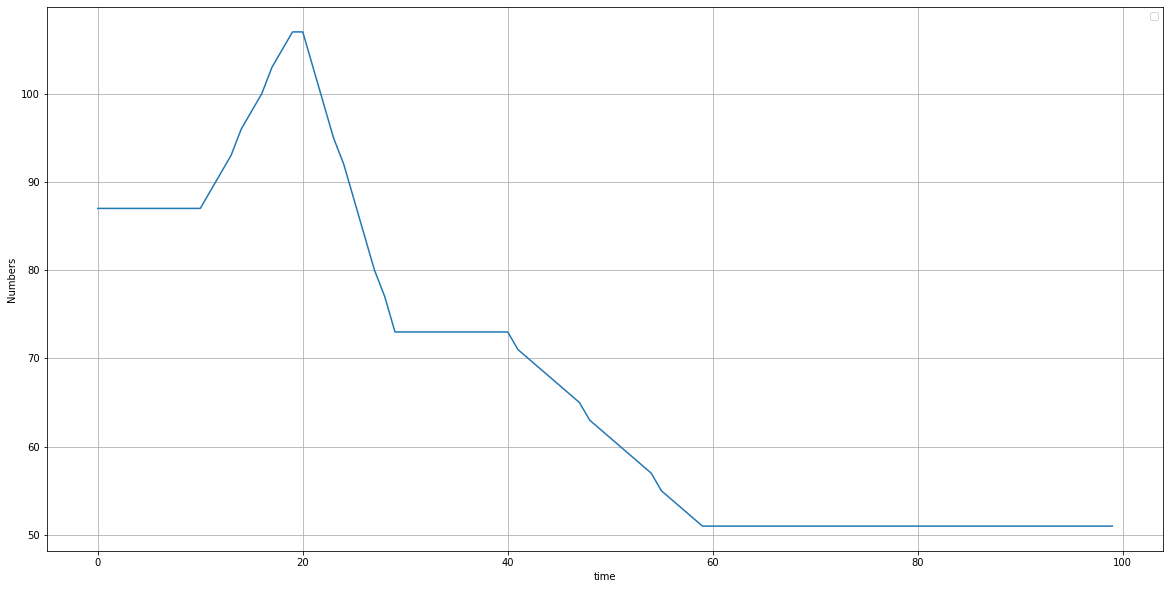

In [61]:
randid = np.random.randint(200)
print(tracker.iloc[randid]['event'])
visualize_sample(samples[randid])

In [7]:
pickle.dump(samples, open("data/dev/sample_7_patterns.pkl", "wb"))
tracker.to_pickle('data/dev/tracker_7_patterns.pkl')

In [4]:
samples = pickle.load(open("data/dev/sample_7_patterns.pkl", "rb"))
tracker = pd.read_pickle('data/dev/tracker_7_patterns.pkl')

In [5]:
tracker.head()

,category,event,pivots
0,luonto,up_down,"[5, 86]"
1,työllisyys,noise,[]
2,taudit,up_down,"[7, 95]"
3,työllisyys,up,"[23, 82]"
4,ruoat,down,"[25, 96]"


In [10]:
def create_cluster_data(samples, tracker, n=10, n_event=1):
    df_noise = tracker[tracker['event'] == 'noise']
    df_change = tracker[tracker['event'] != 'noise']
    
    data = []
    # generate n cluster for each samples, from 5 to 12, with prob for 12 is most
    n_clusters = np.random.choice(range(5, 13), size=n, p=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3])
    
    for i in range(n):
        df_data = []
        unique_cats = []
        n_cluster = n_clusters[i]
        # select one
        
        while len(unique_cats) < n_event:
            target = df_change[~df_change['category'].isin(unique_cats)].sample(1).iloc[0]
            
            if target['category'] in unique_cats:
                continue
            else:
                sample = samples[target.name]
                sample['event'] = target['event']
                unique_cats.append(target['category'])
                df_data.append(sample)
        
        while len(unique_cats) < n_cluster:
            # print(unique_cats)
            noise = df_noise[~df_noise['category'].isin(unique_cats)].sample(1).iloc[0]
            # print(noise)
            
            if noise['category'] in unique_cats:
                continue
            else:
                sample = samples[noise.name]
                sample['event'] = noise['event']
                unique_cats.append(noise['category'])
                df_data.append(sample)
            
        df_data = pd.concat(df_data, ignore_index=True)
        data.append(df_data)
    
    return data


In [11]:
%%time
dataset = create_cluster_data(samples, tracker, n=10, n_event=1)

CPU times: user 186 ms, sys: 5.99 ms, total: 192 ms
Wall time: 189 ms


In [10]:
pickle.dump(dataset, open("data/dev/dataset_1_event.pkl", "wb"))

In [7]:
dataset = pickle.load(open("data/dev/dataset_1_event.pkl", "rb"))

In [26]:
def save_dataset_folder(dataset):
    for i, df in enumerate(dataset):
        df.to_json('data/dev/dataset/sample_' + str(i) + '.json')

In [27]:
%%time
save_dataset_folder(dataset)

CPU times: user 2min 50s, sys: 7.18 s, total: 2min 58s
Wall time: 5min 9s


In [17]:
rand_id = np.random.randint(10)
df_sample = dataset[rand_id]

In [18]:
df_sample.head()

,id,category,time,event
0,3-5420741,rikokset,0,down
1,3-9680082,rikokset,0,down
2,3-6758211,rikokset,0,down
3,3-9194366,rikokset,0,down
4,3-8725027,rikokset,0,down


In [19]:
def get_sample_text(df_text, sample_ids):
    df = df_text.reset_index(drop=True)
    df = df.set_index('id')

    df_sample = df.loc[sample_ids]
    
    return df_sample

In [20]:
df_sample_text = get_sample_text(df, df_sample['id'])

In [21]:
df_sample_text.head()

,date,title,body,subjects,category
id,,,,,
3-5420741,2011-09-09T17:04:26+0300,Seksityöaktivistit vastustavat seksin oston tä...,Helsinkiin kokoontuneet pohjoismaiset seksity...,"[kotimaan uutiset, prostituutio, seksin ostami...",rikokset
3-9680082,2017-06-20T07:03:51+0300,Hallitus kiistää vakoilun,Vakoiluviestejä on lähetetty niin laajamittai...,"[meksiko, vakoiluohjelma, ulkomaat, tiedustelu...",rikokset
3-6758211,2013-08-01T11:12:32+0300,KHO kumosi Viestintäviraston päätöksen Itellan...,"Korkein hallinto-oikeus katsoi, että Viestint...","[kotimaan uutiset, posti group oyj, viestintäv...",rikokset
3-9194366,2016-09-27T14:48:01+0300,Kolme kertaa kaivinkoneen päälle,Pyhäjoen ydinvoimala-alueen työkoneiden pääl...,"[rikos (tv-sarja), fennovoima, aktivismi, rang...",rikokset
3-8725027,2016-03-07T16:45:59+0200,Poliisi: Yhteys Veikoon vain lehdistön kautta,Salaperäisen virolaisen Veikon väitteet Helsi...,"[kotimaan uutiset, jari aarnio, huumepoliisi, ...",rikokset


In [22]:
df_sample[df_sample['event'] == 'noise'].category.unique()

array(['autot', 'tulipalot', 'työllisyys', 'musiikki'], dtype=object)

In [23]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32521 entries, 0 to 32520
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32521 non-null  object
 1   category  32521 non-null  object
 2   time      32521 non-null  int64 
 3   event     32521 non-null  object
dtypes: int64(1), object(3)
memory usage: 1016.4+ KB


In [24]:
def visualize_trending(df):
    # target = df[df['target'] == True]
    # noise = df[df['target'] == False]
    # t_group = target.groupby(['time'])['id'].count()
    n_group = df.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in n_group:
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

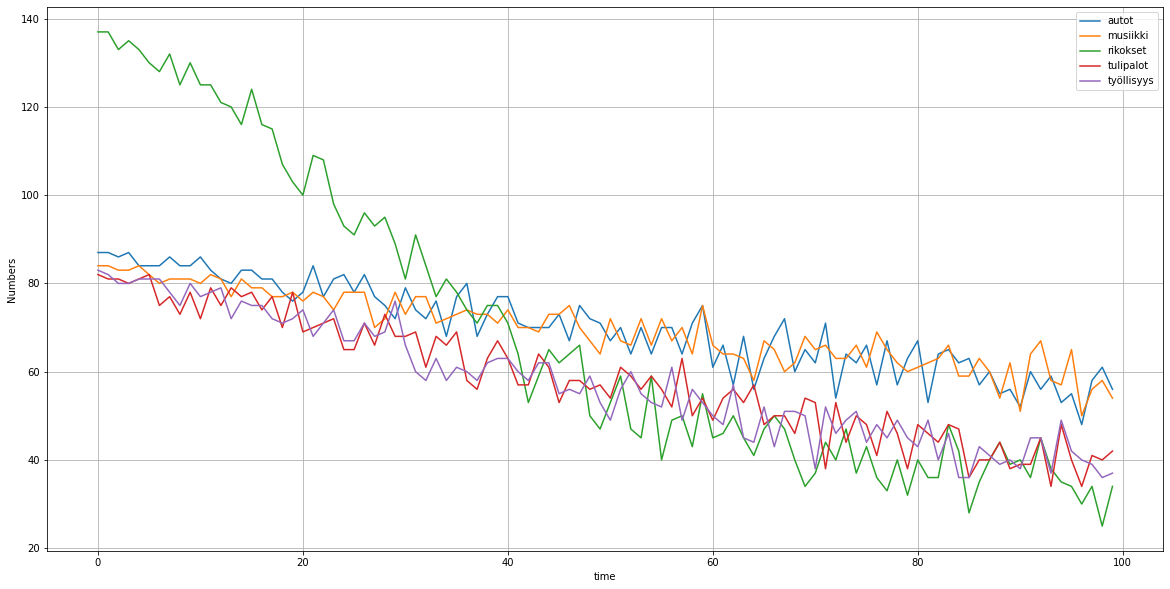

In [25]:
visualize_trending(df_sample)

In [20]:
df_sample['time'].nunique()

100